# Week 2: Building a MVP model
### Pipeline: Preprocessing + TF-IDF + Multinomial Naive Bayes

In [1]:
import re
import string
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
dir_data = '../data/nba_reg18/'

ds_sub = pd.DataFrame()
ds_com = pd.DataFrame()

nf_subs = 7 #7 files for submissions
nf_coms = 12 #12 files for comments

In [3]:
for icom in range(1, nf_subs+1):
    path_ds = dir_data + 'nba_submissions_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_sub = ds_sub.append(ds_cur).drop_duplicates()

In [4]:
for icom in range(1, nf_coms+1):
    path_ds = dir_data + 'nba_comments_reg18_' + str(icom) + '.csv'
    ds_cur = pd.read_csv(path_ds, index_col = 0, parse_dates = ['created'])
    ds_com = ds_com.append(ds_cur).drop_duplicates()

In [5]:
print('No. of threads:')
print(ds_sub.shape[0])
print('No. of comments:')
print(ds_com.shape[0])

No. of threads:
92383
No. of comments:
2064767


### Standerdize Team Name

In [6]:
import sys
sys.path.insert(1, '../scripts') #add my scripts path
from teamname_stdize import teamname_stdize

In [7]:
# get rid of the weired pandas float nan
ds_com.loc[ds_com['flair'].isnull().values, 'flair'] = 'NONE'
ds_sub.loc[ds_sub['flair'].isnull().values, 'flair'] = 'NONE'

In [8]:
# mapping to abbrev team name
ds_sub = teamname_stdize(ds_sub.rename(columns={'flair':'team'}))
ds_com = teamname_stdize(ds_com.rename(columns={'flair':'team'}))

In [9]:
# load team names
team_names = pd.read_csv('../data/teams', names = ['name', 'abbrs'])
team_abbrs = team_names['abbrs'].to_list()

In [10]:
print('No. Total threads:')
print(ds_sub.shape[0])
ds_sub = ds_sub.loc[ds_sub['team'].isin(team_abbrs), :]
print('No. Threads for 31 Teams:')
print(ds_sub.shape[0])

No. Total threads:
92383
No. Threads for 31 Teams:
55475


In [11]:
print('No. Total comments:')
print(ds_com.shape[0])
ds_com = ds_com.loc[ds_com['team'].isin(team_abbrs), :]
print('No. comments for 31 Teams:')
print(ds_com.shape[0])

No. Total comments:
2064767
No. comments for 31 Teams:
1562342


In [12]:
# put submissions and comments together
ds = pd.concat([ds_sub[['author', 'team', 'title', 'created']].rename(columns = {'title':'text'}),
                ds_com[['author', 'team', 'text', 'created']]],
               ignore_index = True)

In [13]:
print('No. Total posts:')
print(ds.shape[0])

No. Total posts:
1617817


Text(0, 0.5, '# of Users')

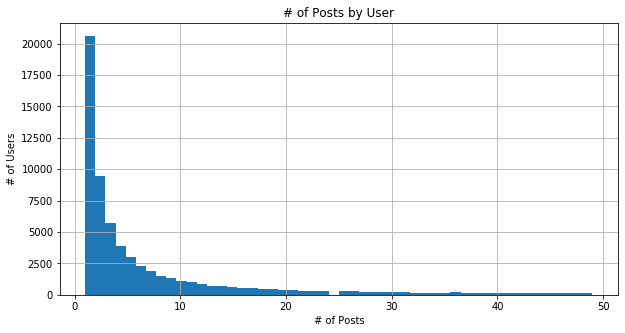

In [14]:
# plot the distribution of No. posts by user
txt_by_au = ds.groupby('author')['author'].count()
txt_by_au[(txt_by_au < 50)].hist(bins = 50, figsize=(10,5))
plt.title('# of Posts by User')
plt.xlabel('# of Posts')
plt.ylabel('# of Users')

Text(0, 0.5, '# of Posts')

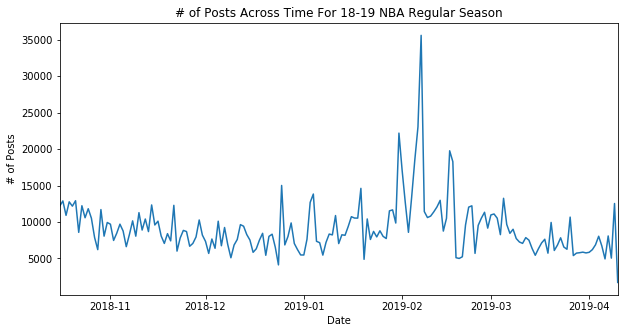

In [15]:
# plot the fluctuation of No. posts across the season by day
daily_posts = ds.groupby(ds['created'].dt.date)['text'].count()
daily_posts[daily_posts.index<date(2019,4,11)].plot(figsize=(10,5))
plt.title('# of Posts Across Time For 18-19 NBA Regular Season')
plt.xlabel('Date')
plt.ylabel('# of Posts')

In [16]:
# look into top days:
daily_posts.sort_values(ascending = False).head(n=20)
# 2/7/2019: trade deadline
# 2/16/2019: all-star weekend
# 12/25/2018: Chrismas games, Lebron James injured

created
2019-02-07    35587
2019-02-06    23043
2019-01-31    22184
2019-02-16    19762
2019-02-05    18475
2019-02-17    18271
2019-02-01    17116
2018-12-25    15008
2019-01-19    14611
2019-01-04    13831
2019-02-04    13354
2019-03-05    13245
2019-02-13    12969
2018-10-21    12914
2018-10-17    12887
2018-10-19    12760
2019-01-03    12685
2019-02-02    12661
2019-04-09    12535
2018-11-14    12335
Name: text, dtype: int64

# Text Preprocessing

In [17]:
from preprocess import preprocess_one

In [18]:
b_punc = True # we do want to remove punctuation
ds['text'] = ds['text'].apply(lambda x: preprocess_one(x, b_punc))

# Prep for Training

In [19]:
# concat all texts by users
ds_user = ds.groupby(['author', 'team'])['text'].apply(lambda x: ' '.join(x)).reset_index()

Text(0, 0.5, '# of Fans')

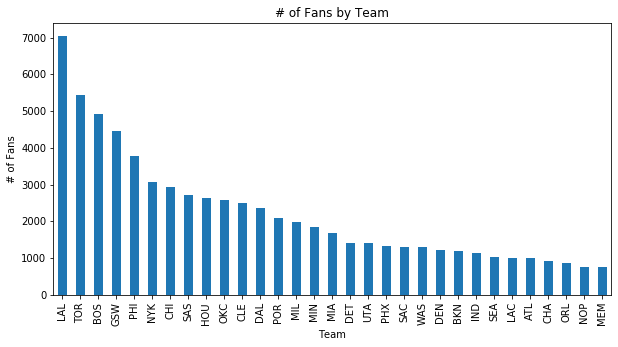

In [20]:
# No. of users by team tags
ds_user.groupby('team')['author'].count().sort_values(ascending=False).plot.bar(figsize=(10,5))
plt.title('# of Fans by Team')
plt.xlabel('Team')
plt.ylabel('# of Fans')

In [21]:
# feature extraction using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=.6)

In [22]:
# split the data to train/test (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds_user['text'], ds_user['team'], test_size=0.20, random_state=0)

In [23]:
# run tf-idf
train_txt = tfidf.fit_transform(X_train)
test_txt = tfidf.transform(X_test)

In [24]:
# train naive bayes
from sklearn.naive_bayes import MultinomialNB
tfidf_nb = MultinomialNB()
tfidf_nb.fit(train_txt, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
print('Accuracy on Training Set:')
print(tfidf_nb.score(train_txt, y_train))

Accuracy on Training Set:
0.2823914823914824


In [26]:
print('Accuracy on Testing Set:')
print(tfidf_nb.score(test_txt, y_test))

Accuracy on Testing Set:
0.27298536798427603


In [27]:
# predict based on priors (baseline model 1), just shuffle the tags
ds_base = ds['team'].to_frame()
ds_base['pred'] = ds_base['team'].sample(frac=1, random_state=0).reset_index(drop=True)
print('Testing accuracy based on prior only:')
print((ds_base['team'] == ds_base['pred']).mean())

Testing accuracy based on prior only:
0.05344053128382258


In [28]:
# theoritical baseline
print('Chance Level:')
print(1/31)

Chance Level:
0.03225806451612903


## Multi-class AUC on testing set

In [29]:
from cal_auc import cal_auc

In [30]:
print('MVP model micro AUC:')
print(cal_auc(tfidf_nb, test_txt, y_test, 'micro'))

MVP model micro AUC:
0.7888612690837313


In [31]:
print('MVP model macro AUC:')
print(cal_auc(tfidf_nb, test_txt, y_test, 'macro'))

MVP model macro AUC:
0.7399316318167074


In [32]:
print('MVP model weighted AUC:')
print(cal_auc(tfidf_nb, test_txt, y_test, 'weighted'))

MVP model weighted AUC:
0.7401592641448181


In [39]:
from sklearn.metrics import matthews_corrcoef
print('MVP model MCC:')
print(matthews_corrcoef(y_test, tfidf_nb.predict(test_txt)))

MVP model MCC:
0.24032247836180187


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, tfidf_nb.predict(test_txt)))

              precision    recall  f1-score   support

         ATL       0.70      0.12      0.21       187
         BKN       0.67      0.07      0.13       243
         BOS       0.39      0.33      0.36       995
         CHA       0.55      0.07      0.12       184
         CHI       0.54      0.17      0.26       583
         CLE       0.59      0.05      0.10       500
         DAL       0.52      0.29      0.37       457
         DEN       0.73      0.14      0.24       256
         DET       0.60      0.11      0.19       280
         GSW       0.29      0.28      0.29       897
         HOU       0.51      0.17      0.26       505
         IND       0.61      0.06      0.11       225
         LAC       0.00      0.00      0.00       195
         LAL       0.15      0.82      0.25      1442
         MEM       0.74      0.11      0.20       150
         MIA       0.63      0.06      0.10       302
         MIL       0.63      0.16      0.26       394
         MIN       0.66    

/home/bearsun/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Cross-Validation

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [36]:
estimators = [('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 1), stop_words='english', max_df=.6)),
              ('clf', MultinomialNB())]
mvp = Pipeline(estimators)

In [37]:
scores = cross_val_score(mvp, X_train, y_train, cv=5, n_jobs = 3)
print('5-fold CV accuracies:')
print(scores)
print('Mean accruacy:')
print(np.mean(scores))

5-fold CV accuracies:
[0.26354545 0.25725198 0.2651984  0.2557589  0.25926938]
Mean accruacy:
0.26020482243249926


In [38]:
auc = cross_val_score(mvp, X_train, y_train, scoring = cal_auc, cv=5, n_jobs = 3)
print('5-fold CV weighted AUCs:')
print(auc)
print('Mean weighted AUC:')
print(np.mean(auc))

5-fold CV weighted AUCs:
[0.73703086 0.73234204 0.73517667 0.72908905 0.73671003]
Mean weighted AUC:
0.7340697294833756
